In [ ]:
from PIL import Image
import requests
from io import BytesIO

import numpy as np
import torch, torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn

# Get Images

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.chosen = [0, 5, 10, 19, 28]
        self.model = torchvision.models.vgg19(pretrained=True).features[:29]

    def forward(self, input):
        features = []
        for layer_numb, layer in enumerate(self.model):
            input = layer(input)

            if layer_numb in self.chosen:
                features.append(input)

        return features

In [ ]:
img_size = 356
transform = torchvision.transforms.Compose([
                                            transforms.Resize((img_size, img_size)),
                                            transforms.ToTensor()
])

In [ ]:
def load_img(url, device=torch.device("cpu")):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = transform(img).unsqueeze(0)
    return img.to(device)

In [ ]:
def load_file(img_name, device=torch.device("cpu")):
    img = Image.open(img_name)
    img = transform(img).unsqueeze(0)
    return img.to(device)

In [ ]:
content_img = load_img("https://cdn.archpaper.com/wp-content/uploads/2020/06/maarten-van-den-heuvel-gZXx8lKAb7Y-unsplash.jpg")
style_img = load_img("https://i.pinimg.com/originals/bb/55/66/bb5566c14a95f1897b1e258e0fcb69fe.jpg")

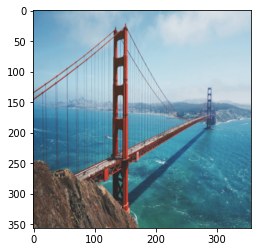

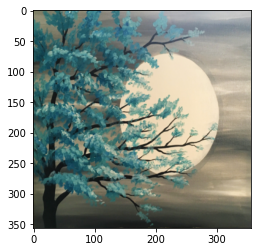

In [ ]:
plt.imshow(content_img.squeeze(0).permute(1, 2, 0))
plt.figure()
plt.imshow(style_img.squeeze(0).permute(1, 2, 0))
plt.show()

In [ ]:
generated_img = content_img.clone().to(device).requires_grad_(True)
# generated_img = torch.randn(orig_img.data.shape, device=device, requires_grad=True)

In [ ]:
model = VGG().eval()

In [ ]:
def train(model, generated_img, content_img, style_img, alpha=1, beta=1, numb_epochs=1, lr=1e-3, device=torch.device("cpu")):
    model = model.to(device)
    generated_img = generated_img.to(device)
    content_img = orig_img.to(device)
    style_img = style_img.to(device)

    optim = torch.optim.Adam([generated_img], lr=lr)
    
    for epoch in range(1, numb_epochs+1):
        generated_features = model(generated_img)
        content_features = model(content_img)
        style_features = model(style_img)

        style_loss = 0
        orig_loss = 0

        for generated_feature, content_feature, style_feature in zip(generated_features, content_features, style_features):
            batch_size, channel_size, height, width = generated_feature.shape
            orig_loss += torch.mean((generated_feature - content_feature) ** 2)

            g = generated_feature.view(channel_size, height * width).mm(
                generated_feature.view(channel_size, height * width).t()
            )

            a = style_feature.view(channel_size, height * width).mm(
                style_feature.view(channel_size, height * width).t()
            )

            style_loss += torch.mean((g - a) ** 2)

        total_loss = alpha * orig_loss + beta * style_loss
        optim.zero_grad()
        total_loss.backward()
        optim.step()

        print(epoch, total_loss.item())
    return generated_img



In [ ]:
res = train(model, generated_img, orig_img, style_img, 1e-2, 1, 1000, 1e-2, device=device)

1 26261848.0
2 15294307.0
3 11429878.0
4 9485851.0
5 8130031.5
6 7234129.5
7 6573463.0
8 6062635.0
9 5647690.5
10 5296044.5
11 4977934.5
12 4678865.5
13 4391181.5
14 4115745.75
15 3851343.75
16 3601086.25
17 3365148.5
18 3145653.25
19 2942731.25
20 2757206.25
21 2586798.25
22 2429614.0
23 2284612.25
24 2151500.5
25 2029092.5
26 1916496.0
27 1812339.375
28 1715846.125
29 1625959.125
30 1542163.75
31 1463830.875
32 1390637.125
33 1322263.875
34 1258385.5
35 1198604.375
36 1142661.75
37 1090156.5
38 1040850.8125
39 994584.75
40 951168.0625
41 910297.375
42 871832.0
43 835789.9375
44 801851.0625
45 769844.0
46 739711.0625
47 711282.75
48 684506.0625
49 659308.6875
50 635639.375
51 613414.5
52 592454.0625
53 572657.1875
54 553907.3125
55 536229.25
56 519545.46875
57 503784.0625
58 488861.53125
59 474751.09375
60 461356.34375
61 448661.0
62 436679.125
63 425284.375
64 414482.96875
65 404253.375
66 394494.875
67 385222.90625
68 376402.40625
69 368044.65625
70 360057.1875
71 352450.96875
72 34

In [ ]:
res = torch.from_numpy(res.cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


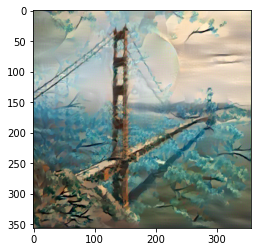

In [ ]:
plt.imshow(res.squeeze(0).permute(1, 2, 0));